Implement a MTZ-like model for the capacitated vehicle routing problem (CVRP).
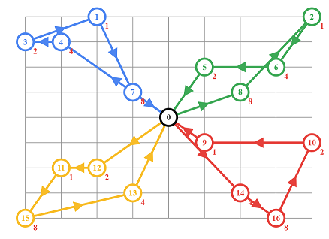

In [1]:
import networkx as nx

k = 4       # number of vehicles
n = 20      # number of demand points

depot = 0                       
dem_points = list(range(1,n+1)) # nodes 1, 2, ..., 20

G = nx.complete_graph(n+1,nx.DiGraph())  

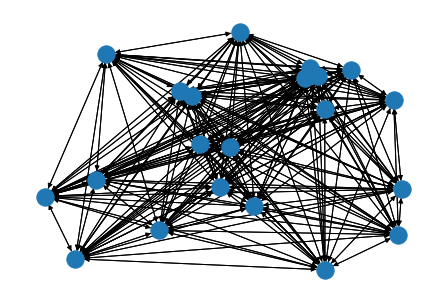

In [2]:
# for convenience, pick the city (x,y)-coordinates at random
import random
my_pos = { i : ( random.random(), random.random() ) for i in dem_points } # pos[i] = (x_i, y_i)

# let's locate the depot in the middle
my_pos[depot] = (0.5, 0.5)

nx.draw(G, pos=my_pos)

In [3]:
# for convenience, suppose that distances are Euclidean
import math
def eucl_dist(x1,y1,x2,y2):
    return math.sqrt( (x1-x2)**2 + (y1-y2)**2 )

for i,j in G.edges:
    (x1,y1) = my_pos[i]
    (x2,y2) = my_pos[j]
    G.edges[i,j]['length'] = eucl_dist(x1,y1,x2,y2)

In [4]:
# suppose each vehicle has capacity 100
Q = 100

# suppose each demand point has demand 20
q = { i : 20 for i in dem_points }

In [5]:
import gurobipy as gp
from gurobipy import GRB

In [6]:
# First, solve a relaxation

m = gp.Model()
x = m.addVars(G.edges,vtype=GRB.BINARY)

m.setObjective( gp.quicksum( G.edges[i,j]['length'] * x[i,j] for i,j in G.edges ), GRB.MINIMIZE )

# Enter each demand point once
m.addConstrs( gp.quicksum( x[i,j] for i in G.predecessors(j) ) == 1 for j in dem_points )

# Leave each demand point once
m.addConstrs( gp.quicksum( x[i,j] for j in G.successors(i) ) == 1 for i in dem_points )

# Leave the depot k times
m.addConstr( gp.quicksum( x[depot,j] for j in G.successors(depot) ) == k )

m.optimize()

Set parameter Username
Academic license - for non-commercial use only - expires 2023-01-01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 41 rows, 420 columns and 820 nonzeros
Model fingerprint: 0xee391baa
Variable types: 0 continuous, 420 integer (420 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Found heuristic solution: objective 12.1370423
Presolve time: 0.00s
Presolved: 41 rows, 420 columns, 820 nonzeros
Variable types: 0 continuous, 420 integer (420 binary)

Root relaxation: objective 4.238141e+00, 49 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       4.2381406    4.23814  0.00%  

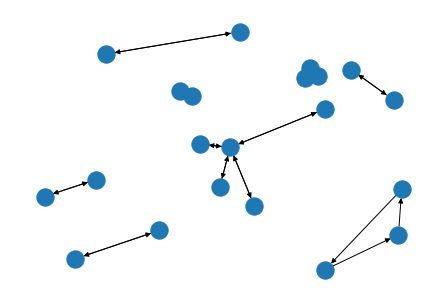

In [7]:
# get the solution and draw it
tour_edges = [ e for e in G.edges if x[e].x > 0.5 ]
nx.draw(G.edge_subgraph(tour_edges), pos=my_pos)

In [8]:
# Add the MTZ variables and constraints, and solve
u = m.addVars( G.nodes )

u[depot].LB = 0
u[depot].UB = 0

for i in dem_points:
    u[i].LB = q[i]
    u[i].UB = Q

c = m.addConstrs( u[i] - u[j] + Q * x[i,j] <= Q - q[j] for i,j in G.edges if j != depot )

m.optimize()

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 441 rows, 441 columns and 2020 nonzeros
Model fingerprint: 0x8fef18a6
Variable types: 21 continuous, 420 integer (420 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [3e-02, 1e+00]
  Bounds range     [1e+00, 1e+02]
  RHS range        [1e+00, 8e+01]

MIP start from previous solve did not produce a new incumbent solution

Presolve removed 20 rows and 1 columns
Presolve time: 0.00s
Presolved: 421 rows, 440 columns, 1960 nonzeros
Variable types: 20 continuous, 420 integer (420 binary)

Root relaxation: objective 4.321147e+00, 122 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    4.32115    0   25          -    4.32115      -     -    0s
H    0  

In [9]:
# Try again, using stronger ("lifted") version of these constraints

m.remove(c)  # remove the previous MTZ constraints
q[depot] = 0
m.addConstrs( u[i] - u[j] + Q * x[i,j] + ( Q - q[i] - q[j] ) * x[j,i] <= Q - q[j] for i,j in G.edges if j != depot )

m.reset()    # start solve process from scratch
m.optimize()

Discarded solution information
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 441 rows, 441 columns and 2420 nonzeros
Model fingerprint: 0xe20dbdb1
Variable types: 21 continuous, 420 integer (420 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [3e-02, 1e+00]
  Bounds range     [1e+00, 1e+02]
  RHS range        [1e+00, 8e+01]
Presolve removed 0 rows and 1 columns
Presolve time: 0.00s
Presolved: 441 rows, 440 columns, 2400 nonzeros
Variable types: 20 continuous, 420 integer (420 binary)
Found heuristic solution: objective 12.2548265

Root relaxation: objective 4.445658e+00, 84 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    4.44566    0   36   12.25483    4.44566  63.7%     -    0s
H    

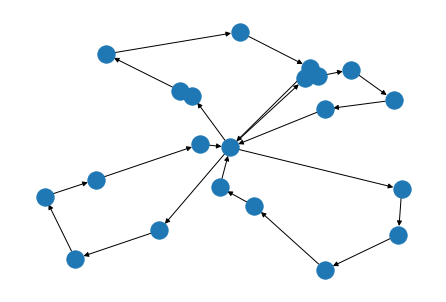

In [10]:
# get the solution and draw it
tour_edges = [ e for e in G.edges if x[e].x > 0.5 ]
nx.draw(G.edge_subgraph(tour_edges), pos=my_pos)